<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/BinarySkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created by Clayton Cohn for the purposes of detecting the existence of causal chains in the Coral Bleaching and Skin Cancer datasets using BERT.

BERT will be fine-tuned for binary classification: 0 indicating the absense of a causal relation and 1 indicating the presence of a causal relation.

The code in this notebook is originally adopted from:

https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=IUM0UA1qJaVB

I have adapted it for use with the Skin Cancer and Coral Bleaching datasets below:

https://knowledge.depaul.edu/display/DNLP/Tasks+and+Data
---


Mount Drive to Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the dataset.

In [2]:
import pandas as pd

DATA_PATH = "drive/My Drive/colab/data/"
DATA_NAME = "EBA1415-SkinCancer-big-sentences.tsv"

df = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=0, names=['essay', 'relation', 's_num', 'sentence'])
df.head(10)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,R-1-2,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,R-1-2,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,O,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,O,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,R-12-3,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,O,10.0,That would be your skin protects you.


Must transform relation labels to binary labels.


In [3]:
relations_pd = df.relation.copy(deep=True)

relations = [
                  "1,2", "1,3", "1,4", "1,5", "1,6", "1,50",
                  "2,3", "2,4", "2,5", "2,6", "2,50",
                  "3,4", "3,5", "3,6", "3,50",
                  "4,5", "4,6", "4,50",
                  "5,6", "5,50",
                  "11,12", "11,6", "11,50",
                  "12,6", "12,50",
                  "6,50"     
                 ]

print("{} unique skin cancer relations".format(len(relations)))

for i, rel in relations_pd.items():
  chain = rel.split("-")
  if chain[0] != "O":

    chain = chain[1] + "," + chain[2]

    if chain in relations:
      relations_pd.at[i] = 1
      continue
    
  relations_pd.at[i] = 0

df_binary = df.copy(deep=True)
df_binary.head(10)

26 unique skin cancer relations


,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,R-1-2,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,R-1-2,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,O,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,O,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,R-12-3,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,O,10.0,That would be your skin protects you.


In [4]:
df_binary.relation = relations_pd
df_binary.head(10)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,0,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,0,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,0,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,0,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,1,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,1,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,0,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,0,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,0,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,0,10.0,That would be your skin protects you.


Next, we must address the issue that some sentences have multiple relations. This could be a problem if a sentence has one valid relation and one invalid one (the same sentence will be labeled True in one instance and False in another instance). To correct this, we will remove the duplicate instances and define each sentence to be True if it contains *at least one* causal relation.

The parse was provided by @TrentonMcKinney on StackOverflow:
https://stackoverflow.com/questions/63697275/regex-string-for-different-versions/63697498#63697498

In [5]:
df_duplicate_sentences = df_binary[df_binary.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences.head(25)

,essay,relation,s_num,sentence
25,EBA1415_SDMK_6_SC_ES-06292,1,26.1,If you are between the Tropics of Cancer and c...
26,EBA1415_SDMK_6_SC_ES-06292,1,26.2,If you are between the Tropics of Cancer and c...
70,EBA1415_KYNS_4_SC_ES-05404,1,70.1,"With more consisten sunlight, Out skinwill bur..."
71,EBA1415_KYNS_4_SC_ES-05404,1,70.2,"With more consisten sunlight, Out skinwill bur..."
80,EBA1415_TFBM_1_SC_ES-05442,1,79.1,Latitude and direct sunlight also has to do wi...
81,EBA1415_TFBM_1_SC_ES-05442,1,79.2,Latitude and direct sunlight also has to do wi...
90,EBA1415_TWMD_6-7_SC_ES-05001,1,127.1,Some things that may lead to skin cancer would...
91,EBA1415_TWMD_6-7_SC_ES-05001,1,127.2,Some things that may lead to skin cancer would...
92,EBA1415_TWMD_6-7_SC_ES-05001,1,127.3,Some things that may lead to skin cancer would...
94,EBA1415_TWMD_6-7_SC_ES-05001,1,129.1,Another way would be by laditude and direct su...


Now that the duplicates are isolated, they need to be evaluated. If there is at least one relation, one copy of the sentence will be kept as true. If there are no relations, one copy will be kept as false.

In [6]:
import numpy as np

current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences.iterrows():
  s_num = str(df_duplicate_sentences.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:
      flag = False
      for n in same_arr_inds:
        if df_duplicate_sentences.loc[n].relation == True:
          flag = True
          break

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if flag == True:
       df_duplicate_sentences.loc[left].relation = 1
      else:
       df_duplicate_sentences.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_binary.drop(drop_list, inplace=True)   

df_binary.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,0,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,0,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,0,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,0,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,1,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,1,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,0,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,0,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,0,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,0,10.0,That would be your skin protects you.


Let's take a look at the breakdown of classes.

In [7]:
df_binary["relation"].value_counts()

0    4795
1    3673
Name: relation, dtype: int64

Data is prepped and cleaned at this point. Next is implementation.

Make sure PyTorch is installed - will use with Hugging Face Transformers

In [8]:
!pip install pytorch-pretrained-bert pytorch-nlp
import torch

Set up GPU.

In [9]:
# Colab currenly defaults to TensorFlow 1.15, but we need 2.0 or greater

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

2.3.0
Found GPU at: /device:GPU:0


'Tesla V100-SXM2-16GB'

Extract sentences and labels from DataFrame. Must also add special [CLS] and [SEP] tokens for BERT.

In [10]:
sentences = df_binary.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = df_binary.relation.values

Tokenize sentences for BERT.

In [11]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'this', 'essay', 'is', 'about', 'skin', 'damage', ',', 'latitude', 'and', 'direct', 'sunlight', ',', 'skin', 'cancer', 'and', 'latitude', ',', 'your', 'skin', 'protects', 'you', 'and', 'about', 'sun', '##burn', '##s', '.', '[SEP]']


For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set

Additionally, we will get rid of the sentences greater than MAX_LEN.

In [12]:
MAX_LEN = 128

original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 10 sentences greater than 128


Convert BERT tokens to corresponding ID numbers in BERT vocabulary.
After conversion, pad the sequences.

In [13]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create attention masks.

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Split data into train, validation, test.

In [15]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Convert sets into Torch tensors.

In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
the entire dataset does not need to be loaded into memory.

In [17]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

Create model.

In [18]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

*   Batch size: 16, 32
*    Learning rate (Adam): 5e-5, 3e-5, 2e-5
*    Number of epochs: 2, 3, 4

In [19]:
LEARNING_RATE = 2e-5
WARMUP = .1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


Time for training.

In [20]:
from tqdm import trange

EPOCHS = 4

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.9457980632281103


Epoch:  25%|██▌       | 1/4 [01:18<03:55, 78.35s/it]

Validation Accuracy: 0.9017857142857143
Train loss: 0.20933964997216933


Epoch:  50%|█████     | 2/4 [02:36<02:36, 78.32s/it]

Validation Accuracy: 0.9145171957671957
Train loss: 0.13860563251792507


Epoch:  75%|███████▌  | 3/4 [03:54<01:18, 78.32s/it]

Validation Accuracy: 0.9118716931216931
Train loss: 0.09220344427691288


Epoch: 100%|██████████| 4/4 [05:13<00:00, 78.29s/it]

Validation Accuracy: 0.9145171957671957


Snapshot of loss over time.

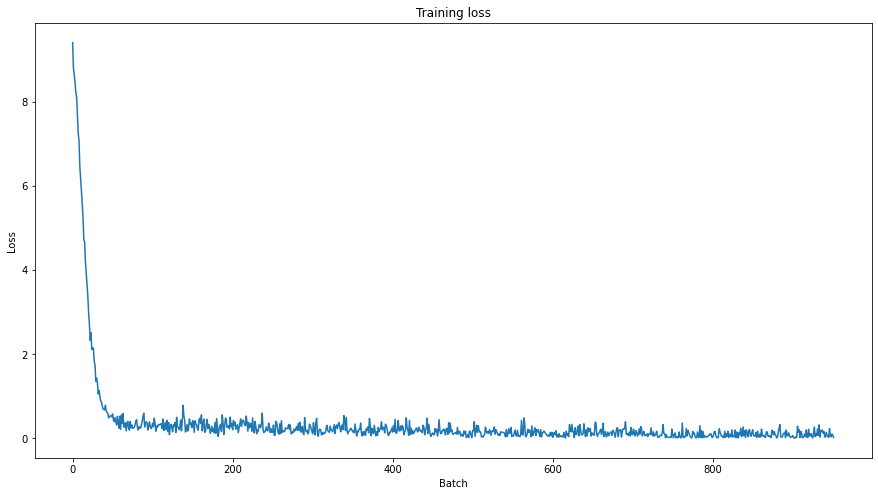

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Test model on testing data.

In [22]:
DATA_NAME = "EBA1415-SkinCancer-little-sentences.tsv"

df_test = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=0, names=['essay', 'relation', 's_num', 'sentence'])

df_test.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,R-1-2,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,R-2-3,3.2,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,R-3-50,7.2,There are two main reasons why people can deve...


Convert testing data labels to binary.

In [23]:
relations_test_pd = df_test.relation.copy(deep=True)
df_binary_test = df_test.copy(deep=True)

for i, rel in relations_test_pd.items():
  chain = rel.split("-")
  if chain[0] != "O":

    chain = chain[1] + "," + chain[2]
    
    if chain in relations:
      df_binary_test.relation.at[i] = 1
      continue
      
  df_binary_test.relation.at[i] = 0

df_binary_test.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,0,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,1,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,1,3.2,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,1,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,1,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,0,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,1,7.2,There are two main reasons why people can deve...


Identify duplicates in test set.


In [24]:
df_duplicate_sentences_test = df_binary_test[df_binary_test.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences_test.head(25)

,essay,relation,s_num,sentence
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,1,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,1,3.2,The reason the sun matters is because of the d...
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,1,7.2,There are two main reasons why people can deve...
10,EBA1415_WSAL_2_SC_ES-05359,1,8.1,It's from radiation and direct sunlight.
11,EBA1415_WSAL_2_SC_ES-05359,1,8.2,It's from radiation and direct sunlight.
17,EBA1415_WSAL_2_SC_ES-05359,1,14.1,If the skin is getting too much radiation or s...
18,EBA1415_WSAL_2_SC_ES-05359,1,14.2,If the skin is getting too much radiation or s...


Remove duplicates from test set.

In [25]:
current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences_test.iterrows():
  s_num = str(df_duplicate_sentences_test.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:
      flag = False
      for n in same_arr_inds:
        if df_duplicate_sentences_test.loc[n].relation == True:
          flag = True
          break

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if flag == True:
       df_duplicate_sentences_test.loc[left].relation = 1
      else:
       df_duplicate_sentences_test.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_binary_test.drop(drop_list, inplace=True)   

df_binary_test.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,0,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,1,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,1,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,0,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
10,EBA1415_WSAL_2_SC_ES-05359,1,8.1,It's from radiation and direct sunlight.
12,EBA1415_WSAL_2_SC_ES-05359,1,9.0,Or just if you receive too much sunlight in ge...
13,EBA1415_WSAL_2_SC_ES-05359,1,10.0,"I read that the closer you are to the Equator,..."


Let's see how the test set's classes break down.

In [26]:
df_binary_test["relation"].value_counts()

0    1252
1     972
Name: relation, dtype: int64

Extract sentences and labels from test data.

In [27]:
sentences_test = df_binary_test.sentence.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]
labels_test = df_binary_test.relation.values.astype(int)
labels_test

array([0, 1, 1, ..., 1, 0, 0])

Tokenize test set essays.

In [28]:
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Set test set attention masks.

In [29]:
attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

Tensorize and load data.

In [30]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

Evaluate test set.

In [31]:
model.eval()

predictions_test, true_labels_test = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits_test)
  true_labels_test.append(label_ids_test)

Print confusion matrix.

In [32]:
from sklearn.metrics import confusion_matrix

flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
flat_true_labels_test = [item for sublist in true_labels_test for item in sublist]

y_pred = flat_predictions_test
y = flat_true_labels_test

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

print("\t\t  Actual\n")
print("\t\tT\tF")
print("\n\t    T {}     {}".format(tp, fp))
print("Predicted")
print("\t    F {}     {}".format(fn, tn))

precision = tp/(tp+fp)
recall = tp/(tp+fn)
tnr = tn/(tn+fp)
fpr = fp/(tn+fp)

print("\nF1:                      {}".format(2*precision*recall/(precision+recall)))
print("Precision:               {}".format(precision))
print("Recall/Sensitivity/TPR:  {}".format(recall))
print("Specificity/TNR:         {}".format(tnr))
print("FPR:                     {}".format(fpr))


		  Actual

		T	F

	    T 860     104
Predicted
	    F 112     1148

F1:                      0.8884297520661157
Precision:               0.8921161825726142
Recall/Sensitivity/TPR:  0.8847736625514403
Specificity/TNR:         0.9169329073482428
FPR:                     0.08306709265175719


Examine statistics from test set.

In [33]:
from sklearn.metrics import classification_report

classification_dict = classification_report(y, y_pred, labels=None, target_names=None, \
                      sample_weight=None, digits=2, output_dict=True, zero_division=1)

for k,v in classification_dict.items():
  print(k, v)

0 {'precision': 0.9111111111111111, 'recall': 0.9169329073482428, 'f1-score': 0.9140127388535032, 'support': 1252}
1 {'precision': 0.8921161825726142, 'recall': 0.8847736625514403, 'f1-score': 0.8884297520661157, 'support': 972}
accuracy 0.9028776978417267
macro avg {'precision': 0.9016136468418626, 'recall': 0.9008532849498416, 'f1-score': 0.9012212454598094, 'support': 2224}
weighted avg {'precision': 0.9028093707606528, 'recall': 0.9028776978417267, 'f1-score': 0.9028316852755622, 'support': 2224}
